In [1]:
cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder
from src.data import get_sim_ness_data as get_data
from amber.architect import pmbga
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import yaml
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


detected tf2 - using compatibility mode


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6se7mthu because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
model_params = yaml.load(open("/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_params.yaml"), Loader=yaml.Loader)
model_params = modelParams_to_modelSpace(model_params)
kinn = KineticModel(model_params)
(x_train, y_train), (x_test, y_test) = get_data()

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn/src/data.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_fit'] = np.clip(df['rate_fit'], 1e-8, 10)


In [4]:
mb = KineticEigenModelBuilder(
        kinn=kinn,
        output_op= lambda: tf.keras.layers.Lambda(
            #lambda x: tf.math.log(tf.math.maximum(tf.reshape(- x[:,1], (-1,1)), 10**-10)), name="output_slice"),
            lambda x: tf.reshape(- x[:,1], (-1,1)), name="output_slice"),
        n_channels=9,
        n_feats=50,
        replace_conv_by_fc=False)

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(7000/128), # decrease every 10 epochs
    decay_rate=0.9,
    staircase=True)
mb.build(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.))
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)


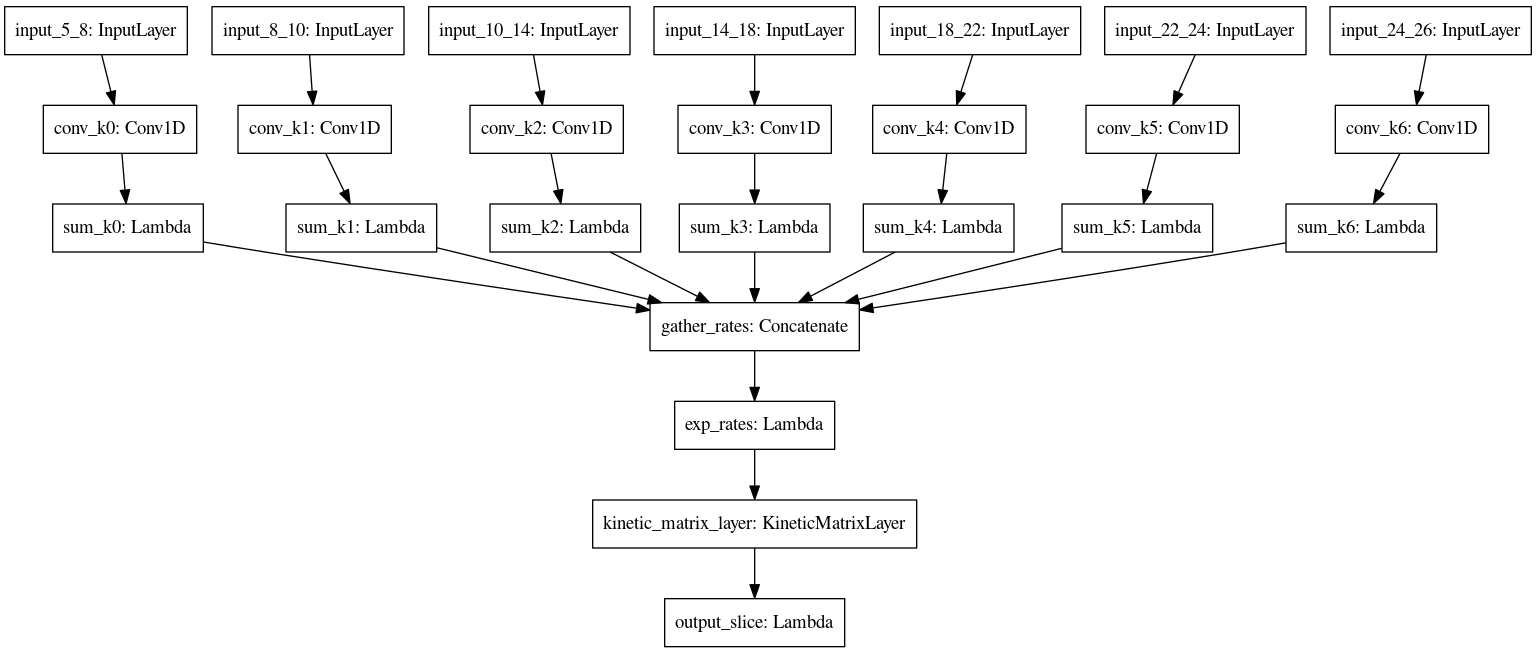

In [5]:
model = mb.model
tf.keras.utils.plot_model(model)

In [6]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=5,
    verbose=0)

hist = model.fit(x_train_b, y_train,
          batch_size=128,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=150, verbose=1)

Train on 3543 samples, validate on 886 samples
Epoch 1/150
3328/3543 [===========================>..] - ETA: 0s - loss: 0.0361

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3543/3543 [==============================] - 1s 267us/sample - loss: 0.0342 - val_loss: 0.0045
Epoch 2/150
3543/3543 [==============================] - 0s 119us/sample - loss: 0.0021 - val_loss: 9.7645e-04
Epoch 3/150
3543/3543 [==============================] - 0s 118us/sample - loss: 6.3123e-04 - val_loss: 3.9794e-04
Epoch 4/150
3543/3543 [==============================] - 0s 119us/sample - loss: 3.0661e-04 - val_loss: 2.4375e-04
Epoch 5/150
3543/3543 [==============================] - 0s 124us/sample - loss: 2.3891e-04 - val_loss: 2.3551e-04
Epoch 6/150
3543/3543 [==============================] - 0s 120us/sample - loss: 2.3370e-04 - val_loss: 2.3028e-04
Epoch 7/150
3543/3543 [==============================] - 0s 122us/sample - loss: 2.2920e-04 - val_loss: 2.2541e-04
Epoch 8/150
3543/3543 [==============================] - 0s 127us/sample - loss: 2.2454e-04 - val_loss: 2.2031e-04
Epoch 9/150
3543/3543 [==============================] - 0s 136us/sample - loss: 2.1967e-04 - val_loss: 

Epoch 72/150
3543/3543 [==============================] - 1s 147us/sample - loss: 6.7464e-05 - val_loss: 6.4067e-05
Epoch 73/150
3543/3543 [==============================] - 0s 135us/sample - loss: 6.6627e-05 - val_loss: 6.3246e-05
Epoch 74/150
3543/3543 [==============================] - 0s 135us/sample - loss: 6.5937e-05 - val_loss: 6.2431e-05
Epoch 75/150
3543/3543 [==============================] - 0s 127us/sample - loss: 6.5155e-05 - val_loss: 6.1692e-05
Epoch 76/150
3543/3543 [==============================] - 0s 121us/sample - loss: 6.4427e-05 - val_loss: 6.0859e-05
Epoch 77/150
3543/3543 [==============================] - 0s 119us/sample - loss: 6.3670e-05 - val_loss: 6.0264e-05
Epoch 78/150
3543/3543 [==============================] - 0s 118us/sample - loss: 6.3013e-05 - val_loss: 5.9519e-05
Epoch 79/150
3543/3543 [==============================] - 0s 122us/sample - loss: 6.2371e-05 - val_loss: 5.8953e-05
Epoch 80/150
3543/3543 [==============================] - 0s 130us/sampl

3543/3543 [==============================] - 0s 130us/sample - loss: 4.3099e-05 - val_loss: 3.9104e-05
Epoch 143/150
3543/3543 [==============================] - 0s 129us/sample - loss: 4.2961e-05 - val_loss: 3.9300e-05
Epoch 144/150
3543/3543 [==============================] - 0s 140us/sample - loss: 4.2983e-05 - val_loss: 3.8987e-05
Epoch 145/150
3543/3543 [==============================] - 0s 139us/sample - loss: 4.2753e-05 - val_loss: 3.8692e-05
Epoch 146/150
3543/3543 [==============================] - 0s 136us/sample - loss: 4.2721e-05 - val_loss: 3.8455e-05
Epoch 147/150
3543/3543 [==============================] - 1s 143us/sample - loss: 4.2404e-05 - val_loss: 3.8415e-05
Epoch 148/150
3543/3543 [==============================] - 1s 142us/sample - loss: 4.2437e-05 - val_loss: 3.8256e-05
Epoch 149/150
3543/3543 [==============================] - 0s 129us/sample - loss: 4.2346e-05 - val_loss: 3.8966e-05
Epoch 150/150
3543/3543 [==============================] - 0s 119us/sample - l

In [7]:
model.load_weights("bestmodel.h5")
y_hat = model.predict(x_test_b).flatten()
test_reward = ss.pearsonr(np.exp(y_hat), np.exp(y_test))[0]
print(test_reward)

0.9729994316090012


Text(0.5, 1.0, 'Pred Eigval vs Fit\npcc=0.973')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


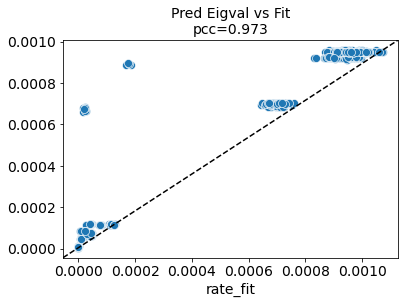

In [8]:
%matplotlib inline
ax = sns.scatterplot(x=y_test, y=y_hat)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Pred Eigval vs Fit\npcc=%.3f' % test_reward)

Text(0.5, 1.0, 'Obs Eigval vs Fit\npcc=0.996')

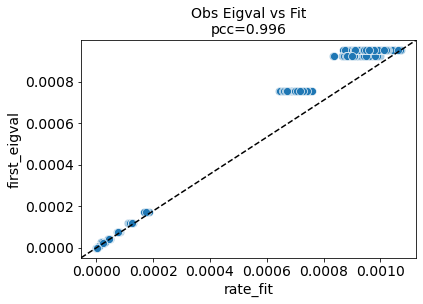

In [9]:
df = pd.read_table('/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_full_data.tsv')
y_eig = - df.loc[y_test.index]['first_eigval']
ax = sns.scatterplot(x=y_test, y=y_eig)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Obs Eigval vs Fit\npcc=%.3f' % ss.pearsonr(y_eig, np.exp(y_test))[0])

In [10]:
df = pd.read_table('/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_full_data.tsv')
df.loc[(y_test - y_hat).abs().sort_values(ascending=False).index].head()

,seq,k_{uo},k_{ou},k_{oi},k_{io},k_{ic},k_{ci},k_{cut},first_eigval,rate_fit,rate_fit_sem,rate_fit_rsqr
2878,TCGGTAGGATCGTAGGGTAGTATTCAGGACCCCGTTAACCATTTCG...,0.001,0.01,0.2,440.529316,5.0,0.003,10.0,-0.000172,0.000176,0.000013,0.998296
2791,TCGGTAGGATCGTAACCTAGTATTCAGGACCCCGTTAACCATTTCG...,0.001,0.01,0.2,440.529316,5.0,0.003,10.0,-0.000172,0.000168,0.000016,0.997102
3427,TCGGTAGGATCGTAGGACAGTATTCAGGACCCCGTTAACCATTTCG...,0.001,0.01,0.2,440.529316,5.0,0.003,10.0,-0.000172,0.000174,0.000020,0.996494
2137,TCGGTAGGATCGTATGCTAGTATTCAGGACCCCGTTAACCATTTCG...,0.001,0.01,0.2,440.529316,5.0,0.003,10.0,-0.000172,0.000177,0.000015,0.997865
3639,TCGGTAGGATCGTAACCTAGTATTCAGGACCCCGTTAACCATTTCG...,0.001,0.01,0.2,440.529316,5.0,0.003,10.0,-0.000172,0.000186,0.000028,0.992800


In [11]:
df.loc[y_test.head().index]

,seq,k_{uo},k_{ou},k_{oi},k_{io},k_{ic},k_{ci},k_{cut},first_eigval,rate_fit,rate_fit_sem,rate_fit_rsqr
3170,TCGGTAGGATCGTAAGATAGTATTCAGGACCCCGTTAATCATTTCG...,0.001,0.01,0.200000,0.02,5.0,0.003,10.000000,-0.000952,0.000980,0.000171,0.998409
2603,TCGGTAGGATCGTAAGATAGTATTTAGGACACCGTTAACCATTTCG...,0.001,0.01,0.200000,0.02,5.0,0.003,3.678794,-0.000952,0.000981,0.000075,0.999691
975,TCGGTAGGATCGTAAGATAGTATTCACGACCCCGTTAACCATTACG...,0.001,0.01,0.200000,0.02,5.0,0.003,10.000000,-0.000952,0.000935,0.000108,0.999367
2203,TCGGTAGGATCGCAAGATAGTATTCAGGACCTCGTTAACCATTTCG...,0.001,0.01,0.000496,0.02,5.0,0.003,10.000000,-0.000043,0.000044,0.000062,0.997767
508,TCTGTAGGATCGTAAGATAGTATTCAGGAACCCGTTAACCATTTCG...,0.001,0.01,0.200000,0.02,5.0,0.003,10.000000,-0.000952,0.000966,0.000080,0.999647


In [12]:
rate_mod = tf.keras.models.Model(inputs=mb.model.inputs, outputs=mb.layer_dict['gather_rates'].output)
pred_rates = rate_mod.predict(mb.blockify_seq_ohe(x_test))
test_df = df.loc[y_test.index]
test_df[['k_%i'%i for i in range(pred_rates.shape[1])]] = np.exp(pred_rates)

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [13]:
name_to_index = {
        'k_{uo}': [((0,0), -1), ((1,0),  1), ],
        'k_{ou}': [((0,1),  1), ((1,1), -1), ],
        'k_{oi}': [((1,1), -1), ((2,1),  1), ],
        'k_{io}': [((1,2),  1), ((2,2), -1), ],
        'k_{ic}': [((2,2), -1), ((3,2),  1), ],
        'k_{ci}': [((2,3),  1), ((3,3), -1), ],
        'k_{cut}':[((3,3), -1), ((4,3),  1), ],
        # for pred
        'k_0': [((0,0), -1), ((1,0),  1), ],
        'k_1': [((0,1),  1), ((1,1), -1), ],
        'k_2': [((1,1), -1), ((2,1),  1), ],
        'k_3': [((1,2),  1), ((2,2), -1), ],
        'k_4': [((2,2), -1), ((3,2),  1), ],
        'k_5': [((2,3),  1), ((3,3), -1), ],
        'k_6':[((3,3), -1), ((4,3),  1), ]

}

def make_kinetic_matrix(vec):
    mat = np.zeros((5,5))
    for name, value in vec.items():
        if not name in name_to_index: continue
        for idx, sign in name_to_index[name]:
            mat[idx] += value * sign
    return mat


def get_first_eigval(vec):
    mat = make_kinetic_matrix(vec)
    eigvals, eigvecs = np.linalg.eig(mat)
    lam_1 = sorted(eigvals, reverse=True)[1]
    return lam_1

#print(np.round([get_first_eigval(r[8:]) for _,r in test_df.iterrows()], 5))
test_df['pred_rate_eigval'] = [get_first_eigval(r[8:]) for _,r in test_df.iterrows()]

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


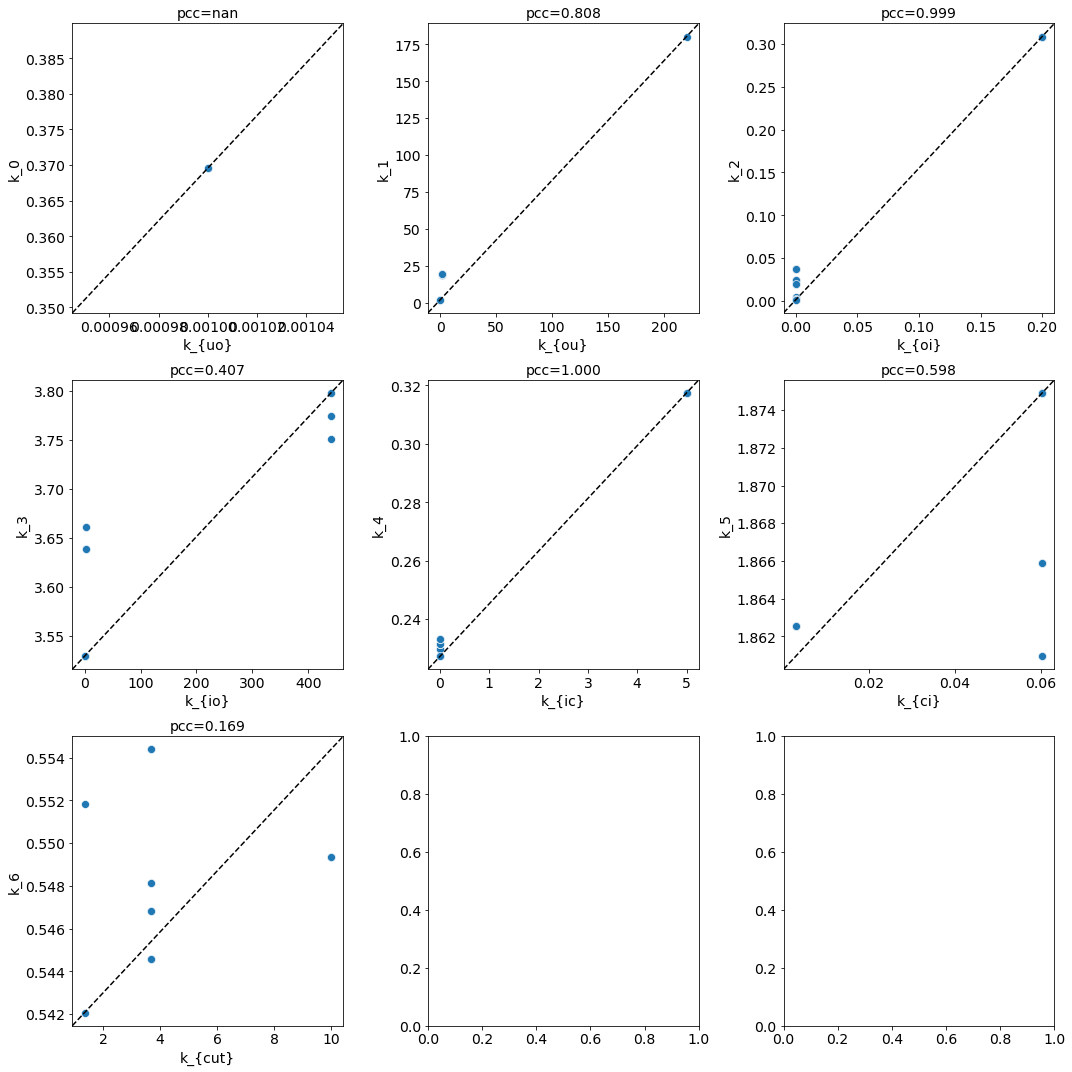

In [14]:
# the rates are not aligned to ground-truth
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for i in range(7):
    ax = sns.scatterplot(x=test_df.iloc[:, 1+i], y=test_df.iloc[:, 12+i], ax=axs[i])
    val_max = min(test_df.iloc[:, 1+i].max(), test_df.iloc[:, 12+i].max())
    #ax.set_xlim(0,val_max)
    #ax.set_ylim(0,val_max)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
    ax.set_title("pcc=%.3f"%ss.pearsonr(test_df.iloc[:, 1+i], test_df.iloc[:, 12+i])[0])
fig.tight_layout()

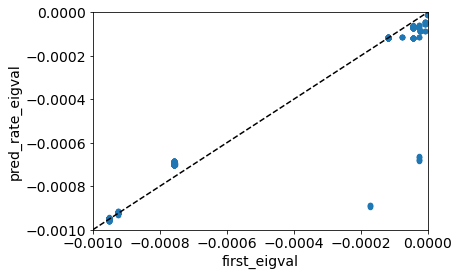

In [15]:
# but the kinetic matrix's eigenvalue are aligned
ax = test_df.plot.scatter(x='first_eigval', y='pred_rate_eigval')
ax.set_xlim(- 10**-3,0)
ax.set_ylim(- 10**-3,0)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')

In [16]:
df.loc[y_test.index]['first_eigval']

3170   -9.519810e-04
2603   -9.519809e-04
975    -9.519810e-04
2203   -4.312197e-05
508    -9.519810e-04
            ...     
2199   -9.519809e-04
599    -9.256779e-04
329    -7.571739e-04
1273   -9.519810e-04
4098   -3.323684e-07
Name: first_eigval, Length: 886, dtype: float64

In [17]:
layer_id = "conv_k0"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[ 0.339]
  [-0.421]
  [ 0.747]
  [-0.124]
  [ 0.5  ]
  [-0.712]
  [ 0.099]
  [ 0.555]
  [-0.601]]]
[-0.332]


In [18]:
layer_id = "conv_k1"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[ 2.26 ]
  [ 2.257]
  [ 2.27 ]
  [ 2.246]
  [-0.136]
  [ 0.62 ]
  [-0.152]
  [-0.635]
  [ 0.7  ]]]
[0.346]


In [19]:
layer_id = "conv_k2"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-2.679]
  [-2.756]
  [-2.102]
  [-2.563]
  [ 0.751]
  [ 0.169]
  [-0.038]
  [ 0.213]
  [ 0.372]]]
[-0.294]


In [20]:
layer_id = "conv_k3"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[ 0.037]
  [ 0.037]
  [ 0.03 ]
  [ 0.03 ]
  [-0.458]
  [ 0.112]
  [-0.192]
  [ 0.726]
  [ 0.205]]]
[0.315]


In [21]:
layer_id = "conv_k4"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-0.334]
  [-0.324]
  [-0.308]
  [-0.315]
  [ 0.534]
  [-0.542]
  [-0.28 ]
  [-0.641]
  [-0.037]]]
[-0.287]


In [22]:
layer_id = "conv_k5"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[ 0.002]
  [-0.001]
  [ 0.007]
  [-0.606]
  [ 0.077]
  [ 0.373]
  [ 0.773]
  [ 0.585]
  [-0.239]]]
[0.311]


In [23]:
layer_id = "conv_k6"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[ 0.009]
  [-0.009]
  [-0.002]
  [-0.005]
  [ 0.693]
  [ 0.664]
  [ 0.587]
  [ 0.274]
  [-0.735]]]
[-0.3]
